In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and Overview

In [59]:
data = pd.read_csv("../data/synthetic/ab_test_fintech_data.csv")

In [60]:
data.head()

,user_id,group,converted,timestamp,clicks,views
0,1,control,0,2025-01-01 00:00:00,2,3
1,2,test,0,2025-01-01 00:01:00,3,5
2,3,control,0,2025-01-01 00:02:00,6,8
3,4,control,0,2025-01-01 00:03:00,1,3
4,5,control,0,2025-01-01 00:04:00,4,4


In [61]:
data.shape

(1000, 6)

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    1000 non-null   int64 
 1   group      1000 non-null   object
 2   converted  1000 non-null   int64 
 3   timestamp  1000 non-null   object
 4   clicks     1000 non-null   int64 
 5   views      1000 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 47.0+ KB


In [63]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,1000.0,500.500,288.819436,1.0,250.75,500.5,750.25,1000.0
converted,1000.0,0.139,0.346120,0.0,0.00,0.0,0.00,1.0
clicks,1000.0,2.957,1.672109,0.0,2.00,3.0,4.00,9.0
views,1000.0,3.929,1.856719,0.0,3.00,4.0,5.00,10.0


# Preparation

In [64]:
# data['timestamp'] = pd.to_datetime(data['timestamp'])

# Analysis Pipeline

In [65]:
import sys
sys.path.append('../src')  # Add the parent directory to the system path

import stats_engine

In [66]:
results = stats_engine.summarize_results(data)

In [67]:
metrics = results['metrics'].copy()
metrics['conversion_rate'] = (metrics['conversion_rate'] * 100).round(1).astype(str) + '%'
metrics['conversion_CI_lower'] = (metrics['conversion_CI_lower'] * 100).round(1).astype(str) + '%'
metrics['conversion_CI_upper'] = (metrics['conversion_CI_upper'] * 100).round(1).astype(str) + '%'

In [68]:
metrics[['group', 'conversion_rate', 'conversion_CI_lower', 'conversion_CI_upper']]

,group,conversion_rate,conversion_CI_lower,conversion_CI_upper
0,control,10.8%,8.1%,13.6%
1,test,16.9%,13.6%,20.1%


In [69]:
t_test = results['t_test']
print("🔍 T-Test:")
print(f"- t-statistic: {t_test['t_stat']:.4f}")
print(f"- p-value: {t_test['p_value']:.4f}")
print(f"- Significant? {'✅ Yes' if t_test['is_significant'] else '❌ No'}")

🔍 T-Test:
- t-statistic: -2.7810
- p-value: 0.0055
- Significant? ✅ Yes


In [70]:
chi2 = results['chi_squared']
print("📈 Chi-Squared Test:")
print(f"- chi2-statistic: {chi2['chi2_stat']:.4f}")
print(f"- p-value: {chi2['p_value']:.4f}")
print(f"- Significant? {'✅ Yes' if chi2['is_significant'] else '❌ No'}")

📈 Chi-Squared Test:
- chi2-statistic: 7.1370
- p-value: 0.0076
- Significant? ✅ Yes


In [71]:
effect = results['effect_size']
print("📐 Effect Size:")
print(f"- Cohen's d: {effect['effect_size']:.4f}")
print(f"- Interpretation: {effect['interpretation']}")

📐 Effect Size:
- Cohen's d: 0.1756
- Interpretation: Small


# Plots

In [72]:
df = data

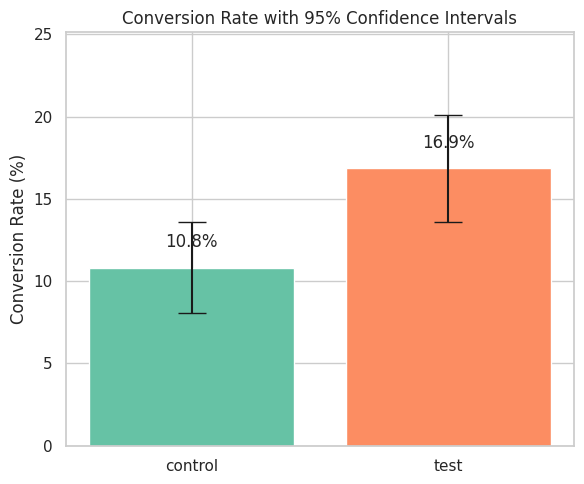

In [ ]:
metrics = results['metrics'].copy()
metrics['conversion_rate'] *= 100
metrics['conversion_CI_lower'] *= 100
metrics['conversion_CI_upper'] *= 100

# Prepare data
groups = metrics['group']
rates = metrics['conversion_rate']
errors = [
    rates - metrics['conversion_CI_lower'],
    metrics['conversion_CI_upper'] - rates
]

# Plot
plt.figure(figsize=(6, 5))
bars = plt.bar(groups, rates, yerr=errors, capsize=10, color=["#66c2a5", "#fc8d62"])
plt.ylabel("Conversion Rate (%)")
plt.title("Conversion Rate with 95% Confidence Intervals")
plt.ylim(0, max(metrics['conversion_CI_upper']) + 5)

# Add text labels
for bar, rate in zip(bars, rates):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1, f"{rate:.1f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [75]:
data['date'] = pd.to_datetime(data['timestamp']).dt.date

In [ ]:
daily_conversion = data.groupby(['date', 'group'])['converted'].mean().reset_index()
daily_conversion['converted'] *= 100  

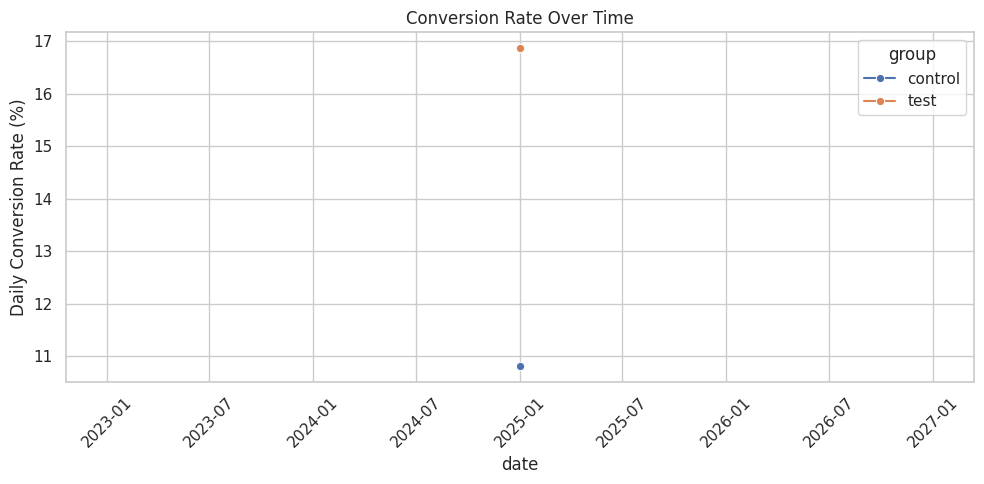

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=daily_conversion, x='date', y='converted', hue='group', marker='o')
plt.ylabel("Daily Conversion Rate (%)")
plt.title("Conversion Rate Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


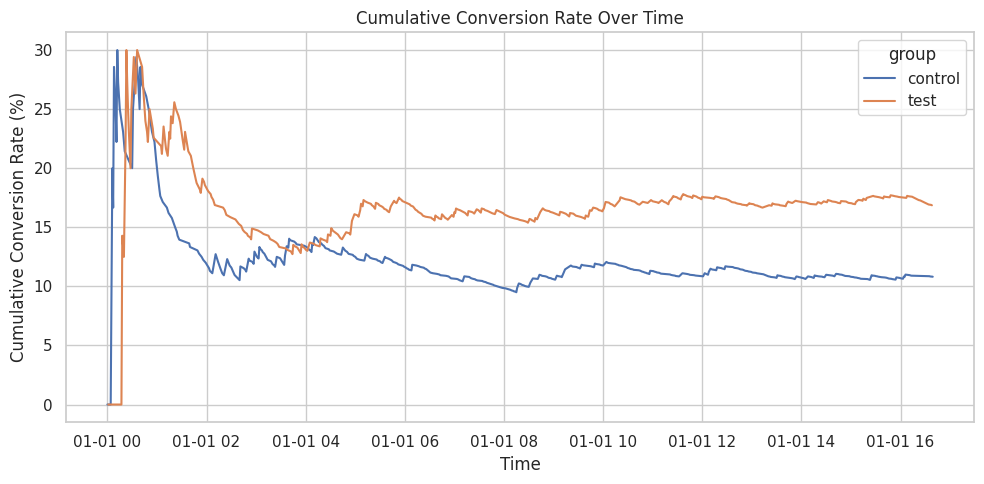

In [79]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df_sorted = df.sort_values('timestamp')

df_sorted['cumulative_converted'] = df_sorted.groupby('group')['converted'].cumsum()
df_sorted['cumulative_total'] = df_sorted.groupby('group').cumcount() + 1

df_sorted['cumulative_rate'] = (df_sorted['cumulative_converted'] / df_sorted['cumulative_total']) * 100

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_sorted, x='timestamp', y='cumulative_rate', hue='group')
plt.title("Cumulative Conversion Rate Over Time")
plt.ylabel("Cumulative Conversion Rate (%)")
plt.xlabel("Time")
plt.tight_layout()
plt.show()


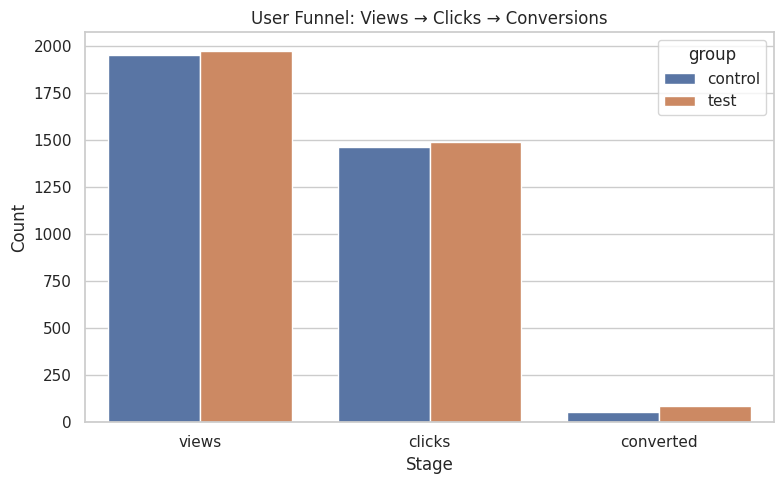

In [80]:
funnel = df.groupby('group')[['views', 'clicks', 'converted']].sum().reset_index()

funnel_data = funnel.melt(id_vars='group', var_name='Stage', value_name='Count')

plt.figure(figsize=(8, 5))
sns.barplot(x='Stage', y='Count', hue='group', data=funnel_data)
plt.title("User Funnel: Views → Clicks → Conversions")
plt.tight_layout()
plt.show()


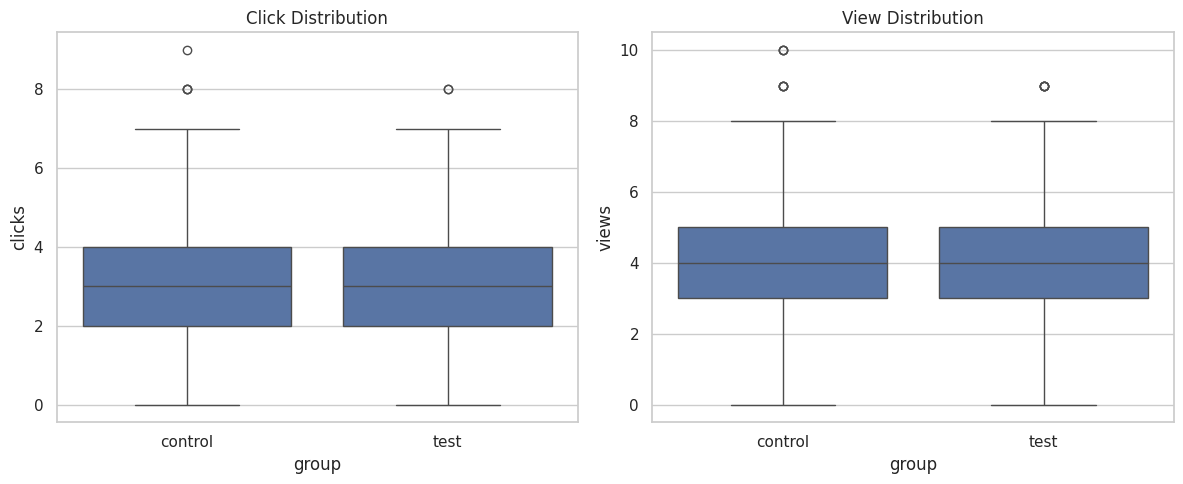

In [81]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='group', y='clicks', data=df)
plt.title("Click Distribution")

plt.subplot(1, 2, 2)
sns.boxplot(x='group', y='views', data=df)
plt.title("View Distribution")

plt.tight_layout()
plt.show()
